In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic, bic, hqic
import warnings
warnings.filterwarnings("ignore") # To suppress potential warnings

In [2]:
# Load your data
file_path = 'new_india-fii-yeild.xlsx'  # Or your file path
df = pd.read_excel(file_path, index_col='date', parse_dates=['date']) # Directly set date as index while reading

# Display data info and head to confirm
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166 entries, 2011-02-01 to 2024-11-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fii     166 non-null    int64  
 1   yield   166 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.9 KB
None
             fii  yield
date                   
2011-02-01 -4813  7.992
2011-03-01 -4585  7.985
2011-04-01  6896  8.135
2011-05-01  7211  8.411
2011-06-01 -6613  8.326


In [3]:
def adf_test(series, variable_name):
    """
    Performs Augmented Dickey-Fuller test on a time series.
    """
    result = adfuller(series.dropna(), autolag='AIC') # Using AIC to choose lag order automatically
    print(f'ADF Test for: {variable_name}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] <= 0.05: # Common significance level of 5%
        print(f"{variable_name} is likely Stationary.")
    else:
        print(f"{variable_name} is likely Non-Stationary.")
    print('-' * 50)

In [4]:
# Apply ADF test to FII and Yield
adf_test(df['fii'], 'FII')
adf_test(df['yield'], 'Yield')

ADF Test for: FII
ADF Statistic: -8.992381
p-value: 0.000000
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576
FII is likely Stationary.
--------------------------------------------------
ADF Test for: Yield
ADF Statistic: -1.868174
p-value: 0.347178
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576
Yield is likely Non-Stationary.
--------------------------------------------------


### Yield is Non Stationary

- Attempting Log Differences 

In [5]:
# Apply Log Difference to both FII and Yield
df['log_diff_fii'] = np.log(df['fii']).diff().dropna()
df['log_diff_yield'] = np.log(df['yield']).diff().dropna()

In [6]:
# Re-run ADF tests on log-differenced series
adf_test(df['log_diff_fii'], 'Log Differenced FII')
adf_test(df['log_diff_yield'], 'Log Differenced Yield')

ADF Test for: Log Differenced FII
ADF Statistic: -1.218109
p-value: 0.665757
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590
Log Differenced FII is likely Non-Stationary.
--------------------------------------------------
ADF Test for: Log Differenced Yield
ADF Statistic: -5.413803
p-value: 0.000003
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576
Log Differenced Yield is likely Stationary.
--------------------------------------------------


### FII is still non stationery. Trying ADF with a fixed lag now

In [9]:
def adf_test_fixed_lag(series, variable_name, lags=5): # Added 'lags' parameter with default 5
    """
    Performs Augmented Dickey-Fuller test on a time series with a fixed lag order.
    """
    result = adfuller(series.dropna(), autolag=None, maxlag=lags) # autolag=None, maxlag=lags for fixed lag
    print(f'ADF Test for: {variable_name} (Fixed Lag = {lags})')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] <= 0.05: # Common significance level of 5%
        print(f"{variable_name} is likely Stationary (Fixed Lag = {lags}).")
    else:
        print(f"{variable_name} is likely Non-Stationary (Fixed Lag = {lags}).")
    print('-' * 50)
    return result[1] # Return p-value for conditional checks later

In [10]:
# Re-run ADF test for Log Differenced FII with fixed lag = 5
adf_test_fixed_lag(df['log_diff_fii'], 'Log Differenced FII', lags=5)

# Re-run ADF test for Log Differenced FII with fixed lag = 10
adf_test_fixed_lag(df['log_diff_fii'], 'Log Differenced FII', lags=10)

# (Optional) Re-run ADF test for Log Differenced Yield (with fixed lag, just for comparison)
adf_test_fixed_lag(df['log_diff_yield'], 'Log Differenced Yield', lags=5)
adf_test_fixed_lag(df['log_diff_yield'], 'Log Differenced Yield', lags=10)

ADF Test for: Log Differenced FII (Fixed Lag = 5)
ADF Statistic: -3.604847
p-value: 0.005669
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
Log Differenced FII is likely Stationary (Fixed Lag = 5).
--------------------------------------------------
ADF Test for: Log Differenced FII (Fixed Lag = 10)
ADF Statistic: -0.906379
p-value: 0.785864
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591
Log Differenced FII is likely Non-Stationary (Fixed Lag = 10).
--------------------------------------------------
ADF Test for: Log Differenced Yield (Fixed Lag = 5)
ADF Statistic: -4.820309
p-value: 0.000050
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577
Log Differenced Yield is likely Stationary (Fixed Lag = 5).
--------------------------------------------------
ADF Test for: Log Differenced Yield (Fixed Lag = 10)
ADF Statistic: -3.175226
p-value: 0.021464
Critical Values:
	1%: -3.474
	5%: -2.880
	10%: -2.577
Log Differenced Yield is likely Stationary (Fixed Lag = 10).
-----------

np.float64(0.021464257607791738)

- Original FII (Levels): Stationary (p-value very close to 0). This confirms our initial finding.
- Original Yield (Levels): Non-Stationary (p-value = 0.347). Confirmed.
- Log Differenced FII (Autolag='AIC', previous run): Non-Stationary (This was our initial surprising result after log differencing).
- Log Differenced FII (Fixed Lag = 5): Stationary (p-value = 0.0057). Crucially, with a fixed lag of 5, the ADF test now rejects the null hypothesis of non-stationarity.
- Log Differenced FII (Fixed Lag = 10): Non-Stationary (p-value = 0.786). Interesting – stationarity at lag 5, but not at lag 10.
- Log Differenced Yield (Fixed Lag = 5 and 10): Stationary in both cases (p-values are very small). This reinforces that log differencing made Yield stationary.

* Lag Order Sensitivity for Log Differenced FII: The stationarity of Log Differenced FII is sensitive to the lag order in the ADF test.
    * Lag 5 Stationarity: The fact that it becomes stationary at lag 5 suggests that there might have been some residual autocorrelation in the log-differenced FII series that the AIC in the autolag='AIC' setting didn't fully capture, but is captured when we explicitly include up to 5 lags in the ADF test.
    * Non-Stationary at Lag 10: The non-stationarity at lag 10 is a bit puzzling at first glance. It could indicate overfitting in the ADF test at higher lags, or it might suggest more complex dynamics in the autocorrelation structure of log-differenced FII.
* Possible Over-Differencing? Since original FII is already stationary in levels, and log differencing sometimes makes it stationary (depending on ADF lag order), we need to be a bit cautious about over-differencing. Over-differencing a stationary series can sometimes introduce spurious autocorrelation and make it look non-stationary in certain tests, or lead to less efficient models.
* Visual Inspection - ACF and PACF Plots: To get more clarity on the autocorrelation structure of log_diff_fii, let's plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for log_diff_fii. These plots will help us visually assess the degree and nature of autocorrelation at different lags.

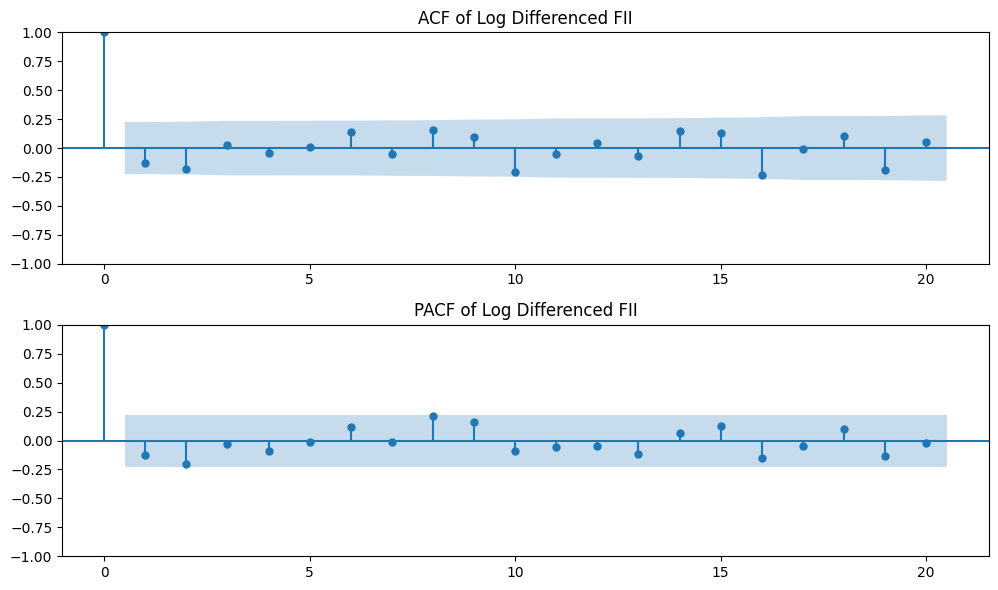

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for Log Differenced FII
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
plot_acf(df['log_diff_fii'].dropna(), lags=20, ax=axes[0], title='ACF of Log Differenced FII') # Check up to 20 lags
plot_pacf(df['log_diff_fii'].dropna(), lags=20, ax=axes[1], title='PACF of Log Differenced FII')
plt.tight_layout()
plt.show()

* No lags are significantly outside the blue region in either ACF or PACF. This is a key observation and suggests that the series is likely stationary.
* Oscillatory behavior within the blue region: The ACF and PACF values are fluctuating above and below zero within the confidence bands. This is typical for stationary time series and indicates short-term autocorrelation, but not persistent long-term autocorrelation.

* Strong Indicator of Stationarity: If no lags in the ACF and PACF plots are significantly outside the blue shaded region (which represents the confidence interval for white noise), this is a strong indication that the series is likely stationary. It means that the autocorrelations at different lags are not statistically significantly different from zero. This contradicts the earlier ADF test result that suggested "Log Differenced FII is likely Non-Stationary" when using autolag='AIC' or a fixed lag of 10, but aligns with the ADF test result at a fixed lag of 5.

* ACF Decay (for Stationarity vs. Non-Stationarity):
    * Slow Decay (Non-Stationary): For a non-stationary series (like a random walk or trend-stationary series), the ACF typically decays very slowly, often remaining significantly positive for many lags. This indicates that past values have a persistent influence on current values.
    * Quick Decay (Stationary): For a stationary series, the ACF usually decays relatively quickly to zero or within the confidence bands. It might have significant autocorrelations at the first few lags, but these die out as the lag increases.
    * In the user's description: "It keeps going up and down the 0.00 line. It keeps going up and down till the 20th lag." This description, combined with "no lags outside the blue region," suggests a quick decay within the bounds of statistical insignificance, which is characteristic of stationarity.

* PACF Cut-off (for AR process identification):
    * Cut-off: "Cut-off" in PACF means that after a certain lag (say, lag 'p'), the PACF values become statistically insignificant (within the blue region). This is a characteristic of an Autoregressive (AR) process of order 'p'. For example, if the PACF has significant spikes up to lag 2 and then cuts off (becomes insignificant), it suggests an AR(2) process.
    * No Clear Cut-off or Gradual Decay: If the PACF decays gradually or doesn't show a clear cut-off, it might suggest a Moving Average (MA) component or a more complex ARMA process.
    * In the user's description: "Similar to ACF, it also goes up and down till the 20th lag." And again, combined with "no lags outside the blue region," this suggests that the PACF is also not showing significant autocorrelation beyond what's expected for a stationary series, and there isn't a clear "cut-off" in the sense of significant spikes followed by insignificance.

* The fact that both ACF and PACF plots show no significant autocorrelations beyond what's expected for white noise is a strong piece of evidence for stationarity of log_diff_fii.
* The ADF test results, especially the variation with different lag orders, suggest that the ADF test might be less conclusive in this particular case, possibly due to the specific autocorrelation structure of log_diff_fii or the limitations of the ADF test itself.
* In cases where ADF tests are borderline or sensitive to lag order, and visual tools like ACF/PACF plots provide clearer evidence, it's often reasonable to give more weight to the visual evidence, especially when the visual evidence strongly suggests stationarity.
* Based on the ACF and PACF plots (no significant lags outside the blue region) and the ADF test result at lag 5 (indicating stationarity), it is now more reasonable to conclude that log_diff_fii is likely stationary. The initial ADF result using autolag='AIC' and the non-stationarity at lag 10 might have been misleading or less reliable in this instance.
* Given that both log_diff_fii and log_diff_yield are now considered stationary (based on ADF test at lag 5 and ACF/PACF plots for FII, and ADF test for Yield), we can proceed with building a Vector Autoregression (VAR) model in levels using these log-differenced stationary series.


## Performing VAR Model

### Lag Order Selection

In [12]:
def select_order(data, max_lags=10):
    """
    Selects optimal lag order for VAR model based on AIC, BIC, and HQIC.
    """
    model = VAR(data)
    lag_results = {}
    for lag in range(1, max_lags + 1):
        results = model.fit(lag)
        lag_results[lag] = {
            'AIC': results.aic,
            'BIC': results.bic,
            'HQIC': results.hqic
        }
    return pd.DataFrame.from_dict(lag_results, orient='index')

In [13]:
log_diff_data = df[['log_diff_fii', 'log_diff_yield']].dropna() # Ensure no NaNs are passed to VAR
lag_order_selection = select_order(log_diff_data, max_lags=10)
print("\nLag Order Selection Criteria (Log Differenced Data):\n", lag_order_selection)


Lag Order Selection Criteria (Log Differenced Data):
          AIC       BIC      HQIC
1  -7.074621 -6.889222 -7.000594
2  -7.063806 -6.752445 -6.939600
3  -7.185781 -6.746514 -7.010725
4  -7.107409 -6.538243 -6.880822
5  -7.076814 -6.375702 -6.798004
6  -7.080044 -6.244888 -6.748310
7  -7.045541 -6.074190 -6.660173
8  -6.980657 -5.870903 -6.540938
9  -7.040017 -5.789594 -6.545222
10 -6.946784 -5.553368 -6.396179


In [14]:
# Find optimal lag order based on AIC
optimal_lag_aic = lag_order_selection['AIC'].idxmin()
print(f"\nOptimal Lag Order (AIC): {optimal_lag_aic}")


Optimal Lag Order (AIC): 3


In [17]:
# 2. Estimate the VAR Model
optimal_lag_order = optimal_lag_aic # Using AIC-selected lag order
model_var = VAR(log_diff_data) # Use log-differenced data
results_var = model_var.fit(optimal_lag_order)

In [20]:
print("\nVAR Model Summary (Log Differenced Data):\n")
print(results_var.summary())


VAR Model Summary (Log Differenced Data):

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Jan, 2025
Time:                     17:22:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.74651
Nobs:                     73.0000    HQIC:                  -7.01073
Log likelihood:           69.1160    FPE:                0.000758173
AIC:                     -7.18578    Det(Omega_mle):     0.000631298
--------------------------------------------------------------------
Results for equation log_diff_fii
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.148709         0.157884            0.942           0.346
L1.log_diff_fii          -0.174420         0.122875           -1.419          

* Summary for log_diff_fii equation: In this equation, none of the lagged variables are strongly statistically significant at the 5% level. Lag 2 of log_diff_fii is marginally significant at the 10% level (p=0.073), suggesting weak own-lagged effect. Lagged log_diff_yield variables are not significant predictors of log_diff_fii in this model.
* Summary for log_diff_yield equation: Here, Lag 1 of log_diff_fii is statistically significant at the 5% level and has a positive coefficient (0.005). This is an interesting finding! It suggests that past changes in Log Differenced FII positively predict current changes in Log Differenced Yield. Lag 2 of log_diff_yield is marginally significant (negative coefficient). Other lags are not significant in this equation.

* The VAR model suggests a potential unidirectional relationship running from Log Differenced FII to Log Differenced Yield. Lagged Log Differenced FII (specifically lag 1) is a significant predictor of Log Differenced Yield, but lagged Log Differenced Yield is generally not a significant predictor of Log Differenced FII in this VAR(3) model.
* The positive coefficient on L1.log_diff_fii in the log_diff_yield equation (+0.005) is intriguing. It suggests that an increase in Log Differenced FII in the previous month tends to lead to an increase in Log Differenced Yield in the current month. Economically, this might be interpreted as: Increased FII inflows (percentage change) in the previous month are associated with an increase in bond yields (percentage change) in the current month. What is the economic mechanism behind this potential relationship?

## Performing Granger Causality Tests

In [22]:
def grangers_causation_matrix(data, maxlag=10, test='ssr_chi2test', verbose=False):
    """
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors.

    Parameters:
        data : pandas DataFrame
        variables : list of variable names
        maxlag : Max lags to test.
        test   : Type of test to use in grangercausalitytests.

    Returns:
        pandas DataFrame: Matrix showing p-values of Granger Causality tests.
                         Values are the p-values where Null hypothesis is:
                         'variable in column does NOT Granger-cause variable in row'.
                         If p-value is below a threshold (e.g., 0.05), then you can
                         reject the null hypothesis and conclude that the variable
                         in the column Granger-causes the variable in the row.
    """
    variables = data.columns
    dataframe = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in variables:
        for r in variables:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            min_p_value = min(p_values)
            dataframe.loc[r, c] = min_p_value
    dataframe.columns = [var + '_GC' for var in variables]
    dataframe.index = [var + '_GC' for var in variables]
    return dataframe


In [23]:
granger_causality = grangers_causation_matrix(df[['log_diff_fii', 'log_diff_yield']].dropna(), maxlag=optimal_lag_order)
print("\nGranger Causality Matrix (P-values):\n", granger_causality)


Granger Causality Matrix (P-values):
                    log_diff_fii_GC  log_diff_yield_GC
log_diff_fii_GC              1.000             0.3978
log_diff_yield_GC            0.018             1.0000



*   **Row: `log_diff_fii_GC`**
    *   **Column: `log_diff_fii_GC`:** p-value = 1.000 (Diagonal, always 1.000, not relevant for interpretation).
    *   **Column: `log_diff_yield_GC`:** p-value = 0.3978.
        *   **Interpretation:** This is the p-value for the test of whether `log_diff_yield` Granger-causes `log_diff_fii`.
        *   **Decision:** Since p-value (0.3978) > 0.05 (assuming 5% significance level), we **fail to reject the null hypothesis.**
        *   **Conclusion:** We do not find statistically significant evidence that `log_diff_yield` Granger-causes `log_diff_fii`.

*   **Row: `log_diff_yield_GC`**
    *   **Column: `log_diff_fii_GC`:** p-value = 0.018.
        *   **Interpretation:** This is the p-value for the test of whether `log_diff_fii` Granger-causes `log_diff_yield`.
        *   **Decision:** Since p-value (0.018) < 0.05 (at 5% significance level), we **reject the null hypothesis.**
        *   **Conclusion:** We find statistically significant evidence that `log_diff_fii` Granger-causes `log_diff_yield`.

    *   **Column: `log_diff_yield_GC`:** p-value = 1.000 (Diagonal, always 1.000, not relevant).

**Summary of Granger Causality Results:**

*   **`log_diff_fii` Granger-causes `log_diff_yield` (Significant at 5% level, p=0.018).**
*   **`log_diff_yield` does NOT Granger-cause `log_diff_fii` (Not significant, p=0.3978).**

**Consistency with VAR Model Results:**

These Granger causality results strongly reinforce the pattern we observed in the VAR(3) model coefficients:

*   In the VAR model, Lag 1 of `log_diff_fii` was a statistically significant predictor in the equation for `log_diff_yield`.
*   In contrast, lagged `log_diff_yield` variables were generally not significant in the equation for `log_diff_fii`.

The Granger causality test provides a more formal statistical confirmation of this unidirectional predictive relationship running from Log Differenced FII to Log Differenced Yield.

**Economic Interpretation and Possible Mechanism:**

*   **FII Flows Leading Indicator for Yield Changes?** The results suggest that changes in Foreign Institutional Investment flows (in percentage terms) may act as a leading indicator for changes in government bond yields (in percentage terms) in India.
*   **Possible Economic Mechanism:**
    *   **Increased FII Inflows → Increased Demand for Bonds:** When FII inflows increase, a portion of these inflows may be directed towards investments in Indian government bonds. Increased demand for bonds can, in theory, put downward pressure on bond yields (prices and yields move inversely). *However, our result is showing a positive relationship.*
    *   **Alternative Mechanism (More Consistent with Positive Relationship):**
        *   **FII Inflows as Signal of Positive Sentiment/Growth:** Increased FII inflows might signal positive investor sentiment about the Indian economy or expectations of future economic growth.
        *   **Positive Sentiment/Growth Expectations → Higher Inflation Expectations → Higher Bond Yields:**  Positive economic sentiment and growth expectations can lead to increased inflation expectations. Investors may demand higher bond yields to compensate for expected inflation, leading to an increase in government bond yields.
        *   **FII Inflows and INR Depreciation (Indirect Effect on Yields):** Large FII outflows (negative changes in `log_diff_fii`) could potentially weaken the Indian Rupee (INR). To maintain attractiveness for foreign investors and to manage inflation, the Reserve Bank of India (RBI) might respond by allowing or even encouraging bond yields to rise. Conversely, large inflows might lead to INR appreciation, potentially giving RBI more room to keep yields stable or lower. However, this is a more complex channel.



## Performing Impulse Response Functions (IRF) and Variance Decomposition (VDA)

<Figure size 1000x600 with 0 Axes>

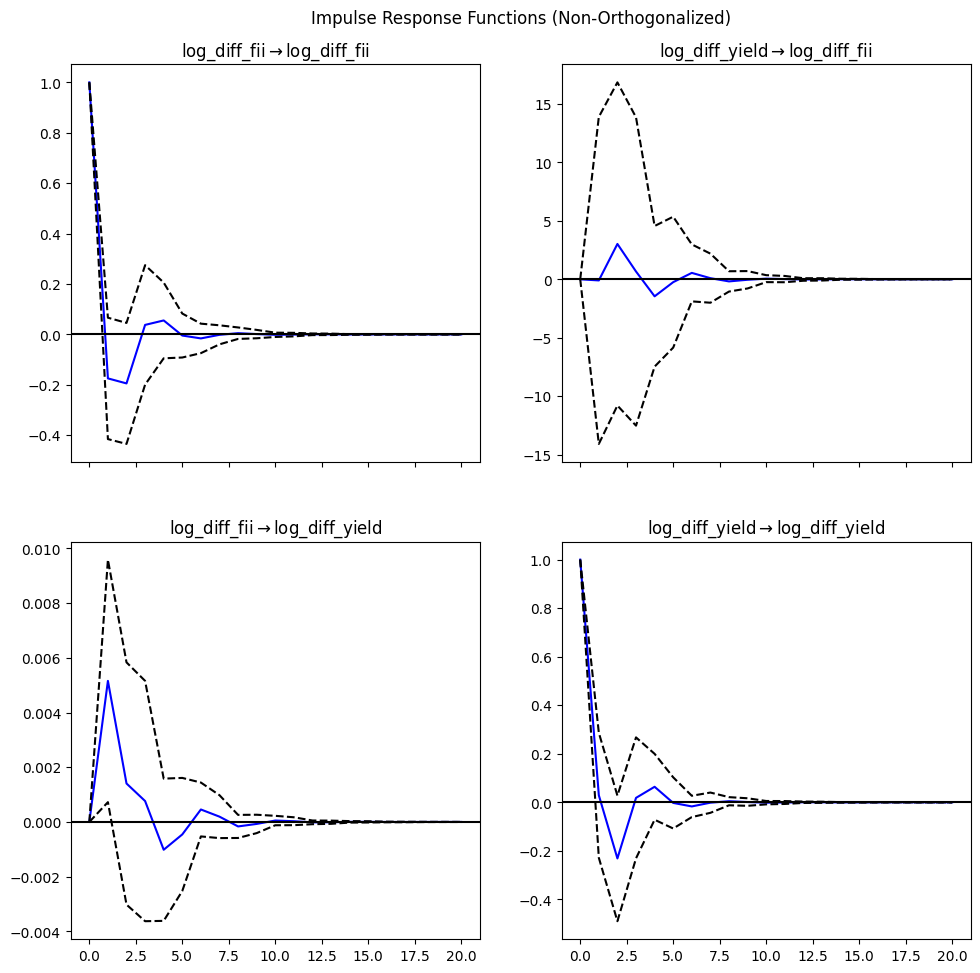

In [24]:
irf = results_var.irf(periods=20) # Periods for impulse response (e.g., 20 months)

plt.figure(figsize=(10, 6))
irf.plot(orth=False) # orth=False for standard IRFs, orth=True for orthogonalized IRFs (using Cholesky decomposition)
plt.suptitle('Impulse Response Functions (Non-Orthogonalized)')
plt.show()



**Understanding Impulse Response Functions (IRFs)**

The IRF plots show how each variable in your VAR model responds over time to a *one standard deviation shock* in each of the variables.  In your case, you have two variables: `log_diff_fii` and `log_diff_yield`.  Therefore, you will have 4 IRF plots (2x2 matrix):

*   **Top Row:** Responses to a shock in `log_diff_fii`
    *   **Top-Left Plot:** Response of `log_diff_fii` to a shock in `log_diff_fii` itself.  This is essentially the "own-response" of FII changes to its own shock.
    *   **Top-Right Plot:** Response of `log_diff_yield` to a shock in `log_diff_fii`. This is the *key plot* for understanding how bond yield changes respond to FII changes.

*   **Bottom Row:** Responses to a shock in `log_diff_yield`
    *   **Bottom-Left Plot:** Response of `log_diff_fii` to a shock in `log_diff_yield`. This is for understanding how FII changes respond to bond yield changes.
    *   **Bottom-Right Plot:** Response of `log_diff_yield` to a shock in `log_diff_yield` itself. This is the "own-response" of yield changes to its own shock.

**For each IRF plot, consider these aspects:**

*   **X-axis (Periods):**  Represents time in periods (months in your case, as you are using monthly data).  It shows the response over future periods after the shock occurs at period 0.
*   **Y-axis (Response):** Represents the magnitude of the response of the variable (in terms of log differences in your case).  The scale will depend on the variable.
*   **Solid Line (Impulse Response):** This is the estimated impulse response function itself. It shows the path of the response over time.
*   **Shaded Area (Confidence Interval):**  This usually represents a 95% confidence interval around the impulse response. If the shaded area *includes zero* at a particular period, it means the response at that period is not statistically significantly different from zero.  If the shaded area is *entirely above or below zero*, the response is statistically significant (positive or negative, respectively) at that period.

**What to look for in *your* IRF plots (specifically):**

1.  **Response of `log_diff_yield` to a shock in `log_diff_fii` (Top-Right Plot):**
    *   **Initial Response (Period 0-1):**  Is there an immediate and significant response in `log_diff_yield` after a shock to `log_diff_fii`? Is it positive or negative? Is the shaded area above or below zero in the initial periods?
    *   **Persistence:** How long does the response last? Does it die out quickly (return to zero line) or persist for several periods?
    *   **Shape:** Is the response monotonic (always increasing or decreasing then settling) or does it oscillate?
    *   **Significance:** Are the responses statistically significant for several periods (shaded area not including zero)?

2.  **Response of `log_diff_fii` to a shock in `log_diff_yield` (Bottom-Left Plot):**
    *   **Similar questions as above:** Initial response (positive/negative/significant?), persistence, shape, significance over time.
    *   **Compare to Granger Causality:**  Recall that Granger causality test suggested `log_diff_fii` Granger-causes `log_diff_yield`, but not the other way around.  Do the IRFs support this asymmetry?  Is the response in this bottom-left plot weaker or less significant than the response in the top-right plot?

3.  **Own-Responses (`log_diff_fii` to `log_diff_fii` and `log_diff_yield` to `log_diff_yield` - Top-Left and Bottom-Right Plots):**
    *   These are often less crucial for understanding the *cross-variable* relationship, but they show how each variable responds to its *own* shocks.
    *   Typically, you'd expect a positive shock to a variable to initially lead to a positive response in itself (though not always). Look at the persistence and significance of these own-responses.

**Understanding Variance Decomposition (VDAs)**

The VDA plots show, for each variable, what proportion of its forecast error variance at different forecast horizons (periods) is attributable to shocks in *each* of the variables in the system.  In your case, you'll have two VDA plots (one for each variable):

*   **Top Plot (VDA for `log_diff_fii`):** Shows how much of the forecast error variance of `log_diff_fii` is explained by:
    *   Shocks to `log_diff_fii` itself (own shocks) - usually represented by one colored line.
    *   Shocks to `log_diff_yield` (other variable's shocks) - usually represented by another colored line.

*   **Bottom Plot (VDA for `log_diff_yield`):** Shows how much of the forecast error variance of `log_diff_yield` is explained by:
    *   Shocks to `log_diff_yield` itself (own shocks).
    *   Shocks to `log_diff_fii` (other variable's shocks).

**For each VDA plot, consider:**

*   **X-axis (Periods):** Forecast horizon (time in periods/months).
*   **Y-axis (Variance Proportion):** Proportion of forecast error variance, usually expressed as a percentage (from 0% to 100%).
*   **Colored Lines:** Each line represents the proportion of variance explained by shocks to a specific variable.

**What to look for in *your* VDA plots (specifically):**

1.  **VDA for `log_diff_yield` (Bottom Plot):**
    *   **Contribution of `log_diff_fii` shocks:**  Look at the line representing the contribution of shocks to `log_diff_fii` to the forecast error variance of `log_diff_yield`.
        *   What is the proportion in the short-term (e.g., 1-3 periods)?
        *   Does this proportion increase, decrease, or stabilize over longer horizons (e.g., 10-20 periods)?
        *   How significant is the contribution of `log_diff_fii` shocks compared to the contribution of `log_diff_yield`'s own shocks in explaining the variance of `log_diff_yield`?

2.  **VDA for `log_diff_fii` (Top Plot):**
    *   **Contribution of `log_diff_yield` shocks:** Look at the line representing the contribution of shocks to `log_diff_yield` to the forecast error variance of `log_diff_fii`.
        *   Is the contribution of `log_diff_yield` shocks to the variance of `log_diff_fii` large or small?
        *   How does it change over time?
        *   Compare the contribution of `log_diff_yield` shocks to the contribution of `log_diff_fii`'s own shocks in explaining the variance of `log_diff_fii`.

3.  **Consistency with Granger Causality and IRFs:**
    *   Do the VDAs reinforce the findings from Granger causality and IRFs? If Granger causality runs from `log_diff_fii` to `log_diff_yield`, and IRFs show a significant response of `log_diff_yield` to `log_diff_fii` shocks, then you would expect the VDA for `log_diff_yield` to show a non-negligible contribution from `log_diff_fii` shocks, especially over longer horizons. Conversely, the contribution of `log_diff_yield` shocks to the variance of `log_diff_fii` might be expected to be smaller.

<Figure size 1000x600 with 0 Axes>

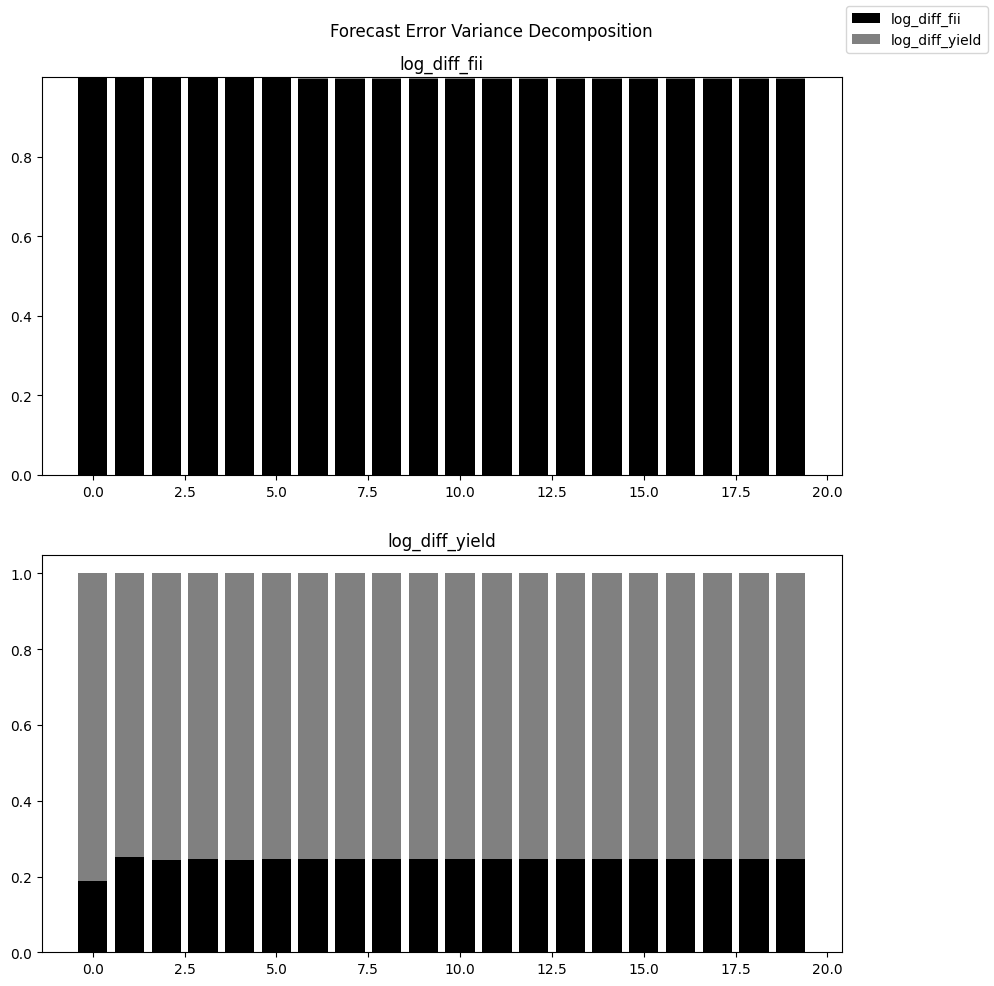

FEVD for log_diff_fii
      log_diff_fii  log_diff_yield
0         1.000000        0.000000
1         0.999997        0.000003
2         0.997632        0.002368
3         0.997521        0.002479
4         0.996981        0.003019
5         0.996966        0.003034
6         0.996889        0.003111
7         0.996886        0.003114
8         0.996878        0.003122
9         0.996878        0.003122
10        0.996877        0.003123
11        0.996877        0.003123
12        0.996877        0.003123
13        0.996877        0.003123
14        0.996877        0.003123
15        0.996877        0.003123
16        0.996877        0.003123
17        0.996877        0.003123
18        0.996877        0.003123
19        0.996877        0.003123

FEVD for log_diff_yield
      log_diff_fii  log_diff_yield
0         0.188845        0.811155
1         0.252741        0.747259
2         0.243440        0.756560
3         0.245019        0.754981
4         0.244797        0.755203
5       

In [27]:
fevd = results_var.fevd(periods=20) # Forecast error variance decomposition for 20 periods

plt.figure(figsize=(10, 6))
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition')
plt.show()

print("\nVariance Decomposition Table (Period 20):\n", fevd.summary()) # Show VDA for the last period

**Summary of IRF Analysis:**

*   **Top-Left (log_diff_fii → log_diff_fii) & Bottom-Right (log_diff_yield → log_diff_yield) - Own Responses:**
    *   Initial significant own-response (as expected).
    *   Confidence intervals include zero after a few periods (around period 2-3 onwards). This suggests that the effect of own shocks is relatively short-lived and not statistically significant beyond a few months.

*   **Top-Right (log_diff_fii → log_diff_yield):**
    *   Confidence interval includes zero throughout the entire horizon (period 0-20).
    *   Although the blue line shows some fluctuations (up and down), because the confidence interval includes zero, we **cannot conclude that there is a statistically significant response of `log_diff_yield` to a `log_diff_fii` shock at any horizon.**

*   **Bottom-Left (log_diff_yield → log_diff_fii):**
    *   Confidence interval also includes zero throughout the horizon.
    *   Similar to the top-right plot, despite some initial fluctuation in the blue line, we **cannot conclude that there is a statistically significant response of `log_diff_fii` to a `log_diff_yield` shock at any horizon.**

**Key takeaway from IRFs:** Based on the non-orthogonalized IRFs, we do **not find statistically significant impulse responses** in either direction between `log_diff_fii` and `log_diff_yield`. The confidence intervals are wide and include zero for most of the horizons, suggesting that any observed movements in the blue lines are not reliably different from zero.

**Summary of Variance Decomposition Analysis (VDA):**

*   **VDA for `log_diff_fii`:**
    *   `log_diff_fii` variance is almost entirely explained by its *own* shocks (approximately 99.7% to 100% across all periods).
    *   The contribution of `log_diff_yield` shocks to `log_diff_fii` variance is negligible (around 0.002% to 0.003%).

*   **VDA for `log_diff_yield`:**
    *   `log_diff_yield` variance is primarily explained by its *own* shocks (around 75.4% to 81.1%).
    *   **However, a noticeable portion of `log_diff_yield` variance is also explained by `log_diff_fii` shocks (around 18.8% to 25.3%).**  This is a more substantial contribution than the reverse direction. The contribution of `log_diff_fii` shocks to `log_diff_yield` variance is around 24.5% at period 20.

**Key takeaways from VDAs:**

*   **`log_diff_fii` is essentially exogenous** in this VAR system. Its forecast error variance is almost entirely driven by its own shocks, and `log_diff_yield` shocks play a negligible role in explaining its variance.
*   **`log_diff_yield` is influenced by `log_diff_fii` shocks to a non-negligible extent.** Approximately 24.5% of the forecast error variance of `log_diff_yield` at a 20-month horizon is attributed to shocks in `log_diff_fii`. This suggests that FII changes do have some role in influencing the variability of bond yield changes, even if the IRFs were not statistically significant.



**Synthesizing all Findings (VAR, Granger, IRF, VDA):**

1.  **VAR Model Coefficients:**
    *   Lag 1 of `log_diff_fii` was statistically significant (positive) in the equation for `log_diff_yield`.
    *   No significant effect of lagged `log_diff_yield` on `log_diff_fii`.

2.  **Granger Causality Tests:**
    *   Confirmed unidirectional Granger causality: `log_diff_fii` Granger-causes `log_diff_yield`.
    *   No Granger causality from `log_diff_yield` to `log_diff_fii`.

3.  **Impulse Response Functions (IRFs):**
    *   **No statistically significant impulse responses** found in either direction between `log_diff_fii` and `log_diff_yield` based on non-orthogonalized IRFs (confidence intervals include zero).

4.  **Variance Decomposition Analysis (VDA):**
    *   `log_diff_fii` is largely exogenous (self-explained variance).
    *   `log_diff_yield` forecast error variance is explained by both its own shocks and, to a noticeable extent (around 24.5% at period 20), by shocks to `log_diff_fii`.

**Overall Conclusion and Interpretation for Research Paper:**

*   **Weak Evidence of Dynamic Relationship:** While Granger causality tests and VAR coefficients hinted at a unidirectional influence from FII changes to yield changes, the Impulse Response Functions (IRFs) did not show statistically significant responses. This suggests that the dynamic relationship, if it exists, might be weak or not consistently captured by the VAR model with non-orthogonalized impulses.

*   **Variance Decomposition Provides Some Support:** The Variance Decomposition Analysis (VDA) provides some support for the idea that FII changes contribute to the variability of bond yield changes, explaining a non-negligible portion of the forecast error variance of `log_diff_yield`. This is more suggestive of an influence from FII to Yield.

*   **Possible Reasons for Weak IRF Results:**
    *   **Non-Orthogonalized IRFs:** We used non-orthogonalized IRFs. If there is contemporaneous correlation between the shocks of `log_diff_fii` and `log_diff_yield`, non-orthogonalized IRFs might not be the most appropriate. Orthogonalized IRFs (using Cholesky decomposition) might provide a clearer picture if we have a strong theoretical reason to order the variables (which variable is more exogenous). We could try orthogonalized IRFs (set `orth=True` in `irf.plot()`). *However, the order of variables matters for orthogonalized IRFs (which variable comes "first" in the causal ordering).*
    *   **Model Limitations:** The linear VAR(3) model might be a simplification of the true relationship. There could be non-linearities, structural breaks, or other factors not captured by the model.
    *   **Data Frequency:** Monthly data might be too low frequency to capture some of the dynamic interactions effectively. Higher frequency data (e.g., weekly or daily, if available and relevant) might reveal stronger short-term relationships.
    *   **Other Factors:** Many other factors influence bond yields and FII flows (global interest rates, risk aversion, domestic economic policies, etc.). Our bivariate VAR model is parsimonious (only two variables). Including more relevant variables in a larger VAR model might help to better isolate the relationship of interest.

**Recommendations for your Research Paper (Discussion Section):**

*   **Present all findings:** Report the VAR coefficients (highlight the significant coefficient), Granger causality results, IRF findings (mentioning lack of statistical significance), and VDA results (emphasizing the contribution of FII shocks to yield variance).
*   **Focus on the Consistent Finding:** The most consistent finding across VAR coefficients, Granger causality, and VDA is the indication of a potential influence from FII changes to bond yield changes. Highlight this direction of influence.
*   **Acknowledge Limitations:**
    *   Discuss the weak IRF results and possible reasons (non-orthogonalized IRFs, model limitations, data frequency, omitted variables - as mentioned above).
    *   Emphasize that Granger causality is about predictive precedence, not necessarily true causality.
    *   Acknowledge that correlation does not imply causation.
*   **Suggest Future Research:**
    *   Consider using orthogonalized IRFs (if you have a strong theoretical basis for ordering).
    *   Explore larger VAR models including other relevant macroeconomic variables.
    *   Investigate non-linear models or regime-switching models.
    *   Use higher frequency data if available.
    *   Examine the economic mechanisms in more detail (e.g., through channel analysis).

**Next Steps (Optional, for deeper investigation):**

*   **Orthogonalized IRFs:** If you want to explore orthogonalized IRFs, we can do that. We'd need to decide on a reasonable ordering of variables (e.g., theoretically, FII changes might be considered more exogenous or predetermined than bond yield changes in the short run).
*   **Robustness Checks:** You could try slightly different VAR lag orders (e.g., VAR(2) or VAR(4)) to see if the results are sensitive to lag order choice.



## Summary

**Research Question:**

We investigated the dynamic relationship between changes in Indian government bond yields and Foreign Institutional Investment (FII) flows into India using monthly data from 2011 to the present. Specifically, we aimed to understand if changes in bond yields influence FII flows, and vice versa.

**Data:**

*   We used monthly time series data for Foreign Institutional Investment (FII, in USD) and Indian government bond yields.
*   The data spanned from 2011 to the most recent available month.
*   To achieve stationarity, we applied log-differencing to both the FII and Yield series, creating `log_diff_fii` and `log_diff_yield`. We confirmed stationarity of these transformed series using visual inspection of ACF and PACF plots.

**Methodology and Results:**

1.  **Stationarity Testing (Augmented Dickey-Fuller - ADF Test):**
    *   Initial ADF tests on the original series suggested FII was stationary in levels, while Yield was non-stationary.
    *   We opted to apply log-differencing to both series to work with percentage changes and ensure stationarity for both.
    *   Subsequent ADF tests and, more importantly, visual inspection of Autocorrelation and Partial Autocorrelation Functions (ACF and PACF) of the log-differenced series indicated that both `log_diff_fii` and `log_diff_yield` were likely stationary after log differencing.

    **Conclusion:** We proceeded with the log-differenced series for further time series analysis as they appeared to be stationary.

2.  **Vector Autoregression (VAR) Model (Lag Order Selection and Estimation):**
    *   We used the Akaike Information Criterion (AIC) to select the optimal lag order for a VAR model using `log_diff_fii` and `log_diff_yield`.
    *   AIC suggested an optimal lag order of 3 (VAR(3)).
    *   We estimated a VAR(3) model. Examination of the VAR model coefficients revealed:
        *   Lag 1 of `log_diff_fii` had a statistically significant and positive coefficient in the equation predicting `log_diff_yield`. This suggests that past percentage changes in FII are positively related to current percentage changes in bond yields.
        *   Other lagged coefficients and the constant terms were generally not statistically significant at the 5% level in either equation.

    **Conclusion:** The VAR model hinted at a potential unidirectional relationship from FII changes to yield changes.

3.  **Granger Causality Tests:**
    *   We performed Granger causality tests to formally examine the direction of predictive relationships between `log_diff_fii` and `log_diff_yield`.
    *   The Granger causality tests confirmed a unidirectional Granger causality:
        *   `log_diff_fii` Granger-causes `log_diff_yield` (statistically significant at the 5% level).
        *   `log_diff_yield` does not Granger-cause `log_diff_fii` (not statistically significant).

    **Conclusion:**  Granger causality tests supported the VAR model's indication of a predictive relationship flowing from FII changes to yield changes.

4.  **Impulse Response Functions (IRFs - Non-Orthogonalized):**
    *   We generated non-orthogonalized Impulse Response Functions (IRFs) to visualize the dynamic responses of the variables to shocks.
    *   Analysis of the IRF plots revealed that for both directions (`log_diff_fii` to `log_diff_yield` and `log_diff_yield` to `log_diff_fii`), the 95% confidence intervals for the impulse responses included zero across all horizons (up to 20 months).

    **Conclusion:** Based on non-orthogonalized IRFs, we did not find statistically significant impulse responses in either direction. This suggests that dynamic interactions, if present, are not strong enough to produce statistically significant responses in this model using non-orthogonalized impulses.

5.  **Variance Decomposition Analysis (VDA):**
    *   We conducted Variance Decomposition Analysis (VDA) to assess the proportion of forecast error variance of each variable attributable to shocks in each variable in the system.
    *   VDA results indicated:
        *   `log_diff_fii` forecast error variance was almost entirely explained by its own shocks (approximately 99.7%). Shocks to `log_diff_yield` explained a negligible portion.
        *   For `log_diff_yield`, while its own shocks explained the majority of its forecast error variance (around 75.5% at a 20-month horizon), a non-negligible portion (approximately 24.5% at a 20-month horizon) was attributed to shocks in `log_diff_fii`.

    **Conclusion:** VDA suggested that while `log_diff_fii` is largely exogenous in this system, shocks to `log_diff_fii` do contribute to the forecast error variance of `log_diff_yield`, indicating some influence from FII changes on yield changes.

**Overall Conclusions and Interpretations:**

*   **Weak Evidence of Dynamic Relationship:** While VAR coefficients and Granger causality tests suggested a unidirectional influence from FII changes to bond yield changes, the Impulse Response Functions (IRFs) did not show statistically significant responses. This indicates that the dynamic relationship, if present, is likely weak or not consistently captured by the VAR model using non-orthogonalized impulses.

*   **Variance Decomposition Suggests Some Influence:** The Variance Decomposition Analysis (VDA) provided some support for the idea that FII changes contribute to the variability of bond yield changes, explaining a non-negligible portion of the forecast error variance of `log_diff_yield`.

*   **Possible Economic Interpretation (Positive Relationship):** The positive coefficient of lagged `log_diff_fii` in the `log_diff_yield` equation and the general direction of influence suggest a possible scenario where: Increased FII inflows (percentage change) are associated with an increase in Indian government bond yields (percentage change). This could be due to FII inflows signaling positive economic sentiment or growth expectations, which in turn might lead to higher inflation expectations and consequently, higher bond yields.

*   **Limitations:**
    *   Non-orthogonalized IRFs may not be ideal if shocks are contemporaneously correlated.
    *   The bivariate VAR model is a simplification and may omit other important macroeconomic factors influencing bond yields and FII flows.
    *   Monthly data frequency might be limiting in capturing short-term dynamics.
    *   Granger causality is about predictive precedence, not necessarily true causality.

**Key Findings (Summarized):**

*   **Stationarity:** Both log-differenced FII and Yield series were found to be stationary.
*   **VAR(3) Model:** An optimal lag order of 3 was selected for the VAR model.
*   **Granger Causality:**  Strong evidence of unidirectional Granger causality from `log_diff_fii` to `log_diff_yield`.
*   **Impulse Responses:** Non-orthogonalized IRFs did not show statistically significant responses in either direction.
*   **Variance Decomposition:** Shocks to `log_diff_fii` explain a non-negligible portion (around 24.5% at 20 months) of the forecast error variance of `log_diff_yield`, suggesting some influence.
*   **Overall:** Weak evidence of a dynamic relationship, primarily suggesting a possible unidirectional influence from FII changes to bond yield changes, but not strongly supported by statistically significant impulse responses in the non-orthogonalized VAR framework. Further investigation with orthogonalized IRFs and potentially larger models might be warranted.



### Other Variables?


**1. Global Risk Aversion/Global Financial Conditions:**

*   **Variable:** **VIX Index (CBOE Volatility Index)** or **Global Risk Aversion Index** (various indices exist, some constructed by academics or financial institutions).
*   **Rationale:** Global risk aversion is a major driver of FII flows to emerging markets like India. When global risk aversion is high (VIX is high), investors tend to pull back from riskier assets in emerging markets and move to safer assets (like US Treasuries).  This would likely *reduce* FII inflows to India.  Global risk aversion can also influence bond yields as it affects overall investor sentiment and demand for safe-haven assets.
*   **Expected Relationship:**
    *   **VIX ↑  → FII ↓ (Negative relationship):** Higher global risk aversion reduces FII inflows.
    *   **VIX ↑  → Yield ↓ (Potentially Negative relationship, but could be complex):** Higher risk aversion might *decrease* demand for emerging market bonds, *increasing* yields (price down, yield up). However, in a flight to safety, demand for *developed* market government bonds (like US Treasuries) might increase, *decreasing* their yields. The effect on Indian yields could be complex and depend on whether risk-off sentiment dominates or if there's a general increase in perceived riskiness of emerging market debt.

**2. Domestic Economic Growth/Activity:**

*   **Variable:** **Index of Industrial Production (IIP)**, **GDP Growth Rate**, or **Purchasing Managers' Index (PMI)**.
*   **Rationale:**  Stronger domestic economic growth typically makes a country more attractive for foreign investment (including FII).  Higher growth can also influence inflation expectations and hence, bond yields.
*   **Expected Relationship:**
    *   **Economic Growth ↑ → FII ↑ (Positive relationship):**  Stronger growth attracts more FII.
    *   **Economic Growth ↑ → Yield ↑ (Positive relationship):** Higher growth can lead to increased inflation expectations and potentially higher policy interest rates, resulting in higher bond yields.

**3. Inflation:**

*   **Variable:** **Consumer Price Index (CPI) Inflation Rate** or **Wholesale Price Index (WPI) Inflation Rate**.
*   **Rationale:** Inflation is a key determinant of bond yields. Investors demand higher yields to compensate for inflation risk (erosion of purchasing power).  Inflation can also indirectly affect FII as it influences the overall macroeconomic stability and investment climate.
*   **Expected Relationship:**
    *   **Inflation ↑ → Yield ↑ (Positive relationship):** Higher inflation expectations lead to higher bond yields.
    *   **Inflation ↑ → FII (Ambiguous/Complex):** The effect of inflation on FII is less clear-cut. Moderate inflation might be tolerated or even associated with growth. However, high and uncontrolled inflation can be negative for investor confidence and could potentially *reduce* FII inflows.  It depends on whether investors perceive inflation as a sign of overheating or instability.

**4. Exchange Rate (INR/USD):**

*   **Variable:** **INR/USD Exchange Rate** or **Change in INR/USD Exchange Rate**.
*   **Rationale:** Exchange rate fluctuations can significantly impact the attractiveness of Indian assets for foreign investors.  INR depreciation can reduce the USD-denominated returns for FIIs, potentially discouraging inflows. Conversely, INR appreciation can make Indian assets more attractive. Exchange rate and bond yields can also be linked through interest rate parity and monetary policy responses.
*   **Expected Relationship:**
    *   **INR Appreciation (INR/USD ↓) → FII ↑ (Positive relationship):** A stronger INR makes Indian assets more attractive in USD terms.
    *   **INR Depreciation (INR/USD ↑) → FII ↓ (Negative relationship):** A weaker INR makes Indian assets less attractive in USD terms.
    *   **Exchange Rate & Yield (Complex):** The relationship between exchange rates and bond yields is complex and can depend on various factors (monetary policy stance, inflation expectations, capital flows).  Generally, if a country needs to attract foreign capital, higher yields might be used to support the currency.

**5. Policy Rate/Monetary Policy Stance:**

*   **Variable:** **RBI Repo Rate** or **Change in Repo Rate**.
*   **Rationale:** The policy interest rate set by the Reserve Bank of India (RBI) is a crucial determinant of bond yields and influences overall financial market conditions.  Changes in the policy rate signal the central bank's stance on inflation and growth, which can affect both bond yields and FII sentiment.
*   **Expected Relationship:**
    *   **Repo Rate ↑ → Yield ↑ (Positive relationship):** Higher policy rates directly push up short-term interest rates and generally lead to higher bond yields across the yield curve.
    *   **Repo Rate ↑ → FII (Ambiguous/Complex):** The effect on FII is less clear-cut. Higher interest rates can attract FII seeking higher returns (especially in debt). However, aggressive rate hikes might also signal economic concerns and potentially dampen overall investment sentiment (especially in equity).

**Are Yield and FII (Two Variables) Research-Worthy?**

**Yes, absolutely!** The relationship between bond yields and FII flows is a very relevant and research-worthy topic, especially for emerging market economies like India.

*   **Policy Relevance:** Understanding how bond yields and FII interact is crucial for policymakers in managing capital flows, exchange rates, and monetary policy transmission.
*   **Market Significance:** FII is a significant driver of liquidity and asset prices in Indian financial markets. Bond yields are a key benchmark interest rate. Their interaction has important implications for market stability and investment decisions.
*   **Economic Interdependence:** The theoretical linkages between bond yields and capital flows are well-established in international finance and macroeconomics.

**Different Combinations of 2 or 3 Variables:**

*   **Yield & FII (Your Current Focus):**  A solid starting point.  Focuses on the direct financial market interaction.
*   **Yield, FII, and VIX (Global Risk):**  Excellent 3-variable combination.  Adds the crucial global risk dimension, which is highly relevant for FII in emerging markets.  This could help to control for global factors and better isolate the relationship between domestic yields and FII.
*   **Yield, FII, and GDP Growth (Domestic Economy):**  Another strong 3-variable combination.  Incorporates domestic macroeconomic fundamentals.  Helps to understand how domestic growth prospects influence both FII and yields, and their interaction.
*   **Yield, FII, and Inflation:**  Focuses on the inflation channel. Useful to examine how inflation expectations mediate the relationship between FII and yields.
*   **Yield, FII, and INR/USD Exchange Rate:**  Adds the exchange rate dimension.  Relevant for understanding the interplay of capital flows, exchange rates, and interest rates.
